# p value comparisons

take the nominal eqtl and pcqtl p values for the lead variant in pcqtl and eqtl credible sets. (or take the permutaiton q values - similar result)

I find that eqtls generally have a lower p value. perhaps some slicing and dicing could give a subset of cases where the pcqtls have a lower p value?


In [1]:
import pandas as pd
import numpy as np
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()


prefix = '/home/klawren/oak/pcqtls'

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *


is this bad to do? does it fall under the comparing p-vals fallecy? I think not, becuase I'm comparing p values as a way to compare the underlying variablity of the data, the effect size and sample size should (in theory) be constant

* comparing p values for the full size data
* comparing p values at each point

In [8]:
main_config_path= f'{prefix}/config/proteincoding_high_corr.yaml'
with open(main_config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_ids = load_tissue_ids(config)
my_tissue_id = 'Muscle_Skeletal'
tissue_ids

['Adipose_Subcutaneous',
 'Adipose_Visceral_Omentum',
 'Artery_Tibial',
 'Cells_Cultured_fibroblasts',
 'Esophagus_Mucosa',
 'Esophagus_Muscularis',
 'Lung',
 'Muscle_Skeletal',
 'Nerve_Tibial',
 'Skin_Not_Sun_Exposed_Suprapubic',
 'Skin_Sun_Exposed_Lower_leg',
 'Thyroid',
 'Whole_Blood']

# with nominal p values

In [ ]:
# look at p values in non overlaping part
e_nominal = load_e_nominal_all_chr(config, tissue_id)
pc_nominal = load_pc_nominal_all_chr(config, tissue_id)
overlap = load_overlap(config, tissue_id)

In [ ]:
# group vep ddf by lead variant
# group by lead variant to prevent varaints from being double counted

# needs tissue id if multiple tissues!!


qtls_grouped = overlap.groupby(['lead_variant_id', 'cluster_id']).agg({'cs_full_id':list, 
                                                                                'orig_cs_dataset':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list, 
                                                                                'lead_variant_pos':'first'}).reset_index() # you could also do a list of varainces
qtls_grouped['num_e_samelead'] = qtls_grouped['cs_full_id'].astype(str).str.count('_e_')/2
qtls_grouped['num_pc_samelead'] = qtls_grouped['cs_full_id'].astype(str).str.count('_pc')
qtls_grouped['exclusive_label'] = np.where((qtls_grouped['num_e_samelead'] > 0), np.where((qtls_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')


In [ ]:
# add in the smallest p value fo re and pc qtls
e_nominal_filtered = e_nominal[e_nominal['variant_id'].isin(overlap['lead_variant_id'])]
pc_nominal_filtered = pc_nominal[pc_nominal['variant_id'].isin(overlap['lead_variant_id'])]

pc_nominal_filtered = pc_nominal_filtered.groupby(['cluster_id', 'variant_id']).agg({'pval_nominal':min})
e_nominal_filtered = e_nominal_filtered.groupby(['cluster_id', 'variant_id']).agg({'pval_nominal':min})

nominal_pvals = pd.merge(e_nominal_filtered, pc_nominal_filtered,  left_on=['cluster_id', 'variant_id'], right_on =['cluster_id', 'variant_id'], suffixes=['_e', '_pc'])
qtls_grouped = pd.merge(qtls_grouped, nominal_pvals, left_on=['cluster_id', 'lead_variant_id'], right_on =['cluster_id', 'variant_id'], suffixes=['', ''])

In [ ]:
ax = sns.scatterplot(qtls_grouped, x='pval_nominal_pc', y='pval_nominal_e')
ax.set_xscale('log')
ax.set_yscale('log')

ax_lims = [.00001,1]
ax_lims = ax.get_ylim()
ax.set_ylim(ax_lims)
ax.set_xlim(ax_lims)

ax.invert_yaxis()
ax.invert_xaxis()

# diagonal line
ax.plot(ax_lims, ax_lims, color='red', linestyle='--')

In [ ]:
qtls_grouped['pval_label'] = np.where(qtls_grouped['pval_nominal_pc'] > qtls_grouped['pval_nominal_e'], 'eqtl_smaller', 'pcqtl_smaller')
sns.countplot(qtls_grouped,  x='pval_label')

# with permutation q values

In [9]:
# get the minimum per cluster p value
pc_pvals = load_pc_cis(config, my_tissue_id).groupby('cluster_id').agg({'qval':min})
e_pvals = load_e_cis(config, my_tissue_id).groupby('cluster_id').agg({'qval':min})

cluster_pvals = pd.merge(pc_pvals, e_pvals, on='cluster_id', suffixes=['_pc','_e'])
cluster_pvals['log_pc_qval'] = np.log10(cluster_pvals['qval_pc'])
cluster_pvals['log_e_qval'] = np.log10(cluster_pvals['qval_e'])

In [10]:
annot_cluster = load_clusters_annotated(config, my_tissue_id)
cluster_pvals = pd.merge(annot_cluster, cluster_pvals, on='cluster_id')

Text(0, 0.5, 'pcqtl min qvalue')

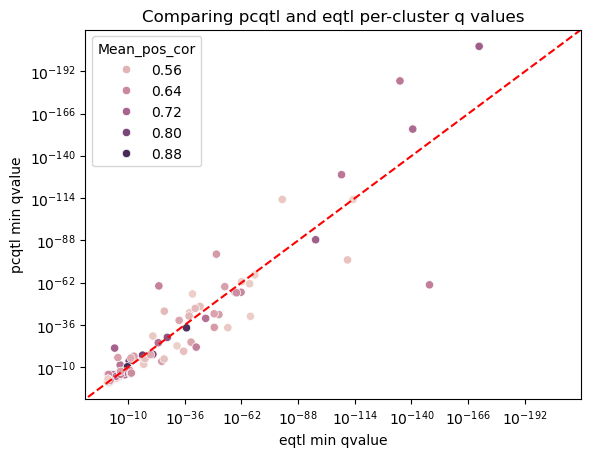

In [13]:
ax = sns.scatterplot(cluster_pvals, y='qval_pc', x='qval_e', hue='Mean_pos_cor')
#ax = sns.regplot(cluster_pvals, y='log_pc_qval', x='log_e_qval', color='k')
ax.set_xscale('log')
ax.set_yscale('log')

ax_lims = [.00001,1]
ax_lims = ax.get_ylim()
ax.set_ylim(ax_lims)
ax.set_xlim(ax_lims)

ax.invert_yaxis()
ax.invert_xaxis()

# diagonal line
ax.plot(ax_lims, ax_lims, color='red', linestyle='--')

ax.set_title('Comparing pcqtl and eqtl per-cluster q values')
ax.set_xlabel('eqtl min qvalue')
ax.set_ylabel('pcqtl min qvalue')

In [6]:
cutoff = .01
pc_better_clusters = cluster_pvals[(cluster_pvals['qval_pc']-cluster_pvals['qval_e']>cutoff)]
e_better_clusters = cluster_pvals[(cluster_pvals['qval_e']-cluster_pvals['qval_pc']>cutoff)]



## regression model - what is different about the clutsers?

In [14]:
pc_better_clusters = []
e_better_clusters = []
total_e_clusters = []
total_pc_clusters = []

# get the minimum per cluster p value
for tissue_id in tissue_ids:
    pc_pvals = load_pc_cis(config, tissue_id).groupby('cluster_id').agg({'qval':min})
    e_pvals = load_e_cis(config, tissue_id).groupby('cluster_id').agg({'qval':min})

    cluster_pvals = pd.merge(pc_pvals, e_pvals, on='cluster_id', suffixes=['_pc','_e'])
    cluster_pvals['log_pc_qval'] = np.log10(cluster_pvals['qval_pc'])
    cluster_pvals['log_e_qval'] = np.log10(cluster_pvals['qval_e'])

    annot_cluster = load_clusters_annotated(config, tissue_id)
    cluster_pvals = pd.merge(annot_cluster, cluster_pvals, on='cluster_id')

    cutoff = .01
    #pc_better_clusters.append(cluster_pvals[(cluster_pvals['qval_pc']-cluster_pvals['qval_e']>cutoff)])
    #e_better_clusters.append(cluster_pvals[(cluster_pvals['qval_e']-cluster_pvals['qval_pc']>cutoff)])
    pc_better_clusters.append(cluster_pvals[(cluster_pvals['qval_pc']<.05)&(cluster_pvals['qval_e']>.05)])
    e_better_clusters.append(cluster_pvals[(cluster_pvals['qval_pc']>.05)&(cluster_pvals['qval_e']<.05)])
    total_e_clusters.append(cluster_pvals[(cluster_pvals['qval_e']<.05)])
    total_pc_clusters.append(cluster_pvals[(cluster_pvals['qval_pc']<.05)])

In [15]:
multitissue_pc_better = pd.concat(pc_better_clusters, keys=tissue_ids, names=['tissue', '.']).reset_index()
multitissue_e_better = pd.concat(e_better_clusters, keys=tissue_ids, names=['tissue', '.']).reset_index()
multitissue_pc = pd.concat(total_pc_clusters, keys=tissue_ids, names=['tissue', '.']).reset_index()
multitissue_e = pd.concat(total_e_clusters, keys=tissue_ids, names=['tissue', '.']).reset_index()

In [16]:
print(len(multitissue_e))
print(len(multitissue_e_better))
print(len(multitissue_pc))
print(len(multitissue_pc_better))

1643
95
1689
141


In [17]:
joined_df = pd.concat([multitissue_pc_better, multitissue_e_better], keys=['pc_better', 'e_better'], names=['type', 'idx'])
joined_df['log_size'] = np.log10(joined_df['cluster_tss_size'])
joined_df['has_multiple_abc_genes'] = joined_df['num_abc_genes'] > 1
joined_df['large_cluster'] = joined_df['N_genes'] > 2

<AxesSubplot: xlabel='Count', ylabel='tissue'>

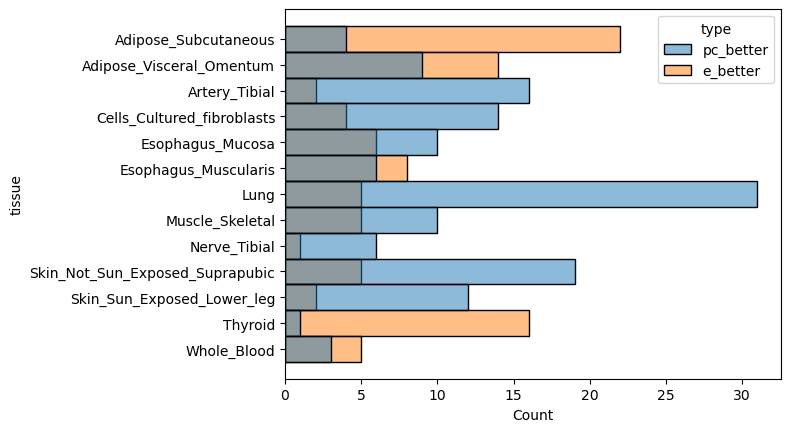

In [18]:
sns.histplot(data=joined_df, hue='type', y='tissue', stat='count', common_norm=False)

<AxesSubplot: xlabel='Mean_cor', ylabel='Percent'>

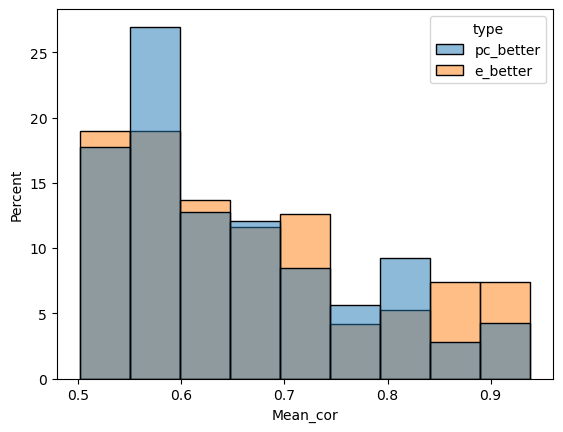

In [19]:
sns.histplot(data=joined_df, hue='type', x='Mean_cor', stat='percent', common_norm=False)

In [20]:
# fit a logit model

def fit_logistic_model(joined_df, column, correct_on=False, filter_on_column=None, verb=True, correct_on_column='log_size'):
    if verb:
        print(column)
    try:
        final_joined_df = joined_df[joined_df[filter_on_column]]
    except KeyError:
        final_joined_df = joined_df

    if correct_on:
        x = final_joined_df[np.append(np.asarray(correct_on_column),column)].astype(float)
    else:
        x = final_joined_df[column].astype(float)

    y = final_joined_df.reset_index()['type'].values == 'pc_better'
    x_with_constant = sm.add_constant(x) # Add intercept term

    logit_model = sm.Logit(y, x_with_constant)
    try:
        result = logit_model.fit()
        
    except np.linalg.LinAlgError:
        # this can happen if all elements are the same
        return pd.Series({'lower_cb':np.nan, 'upper_cb':np.nan, 'odds_ratio':np.nan, 'p_value':np.nan, 'col':column,'lower_cb_diff':np.nan , 'upper_cb_diff':np.nan}, name=column)
    if verb:
        print(result.summary())

    coefficients = result.params
    conf_int = result.conf_int()
    odds_ratios = np.exp(coefficients)
    odds_ratios_ci = np.exp(conf_int)

    odds_ratios_ci.rename(columns={0:'lower_cb', 1:'upper_cb'}, inplace=True)
    odds_ratios_ci['odds_ratio'] = odds_ratios
    odds_ratios_ci['p_value'] = result.pvalues
    odds_ratios_ci['col'] = column
    odds_ratios_ci['lower_cb_diff'] = odds_ratios_ci['odds_ratio'] - odds_ratios_ci['lower_cb']
    odds_ratios_ci['upper_cb_diff'] = odds_ratios_ci['upper_cb'] - odds_ratios_ci['odds_ratio']
    
    return odds_ratios_ci.loc[column]


def get_odds_df(joined_df, verb=True, correct_on=False, correct_on_column='N_genes', column_list = ['large_cluster', 'N_genes', 'has_bidirectional_promoter', 'num_bidirectional_promoter', 'num_shared_enhancers',
       'num_shared_strong_enhancers', 'num_enhancers', 'num_strong_enhancers',
       'num_paralog', 'num_shared_go_all', 'num_shared_go_any','has_shared_enhancer',
       'num_ctcf_peak', 'num_ctcf_point', 'log_size', 'max_jaccard_unweighted', 'max_jaccard_weighted', 'has_tads_tss'], 
       filter_list=['max_jaccard_unweighted', 'max_jaccard_weighted', 'num_shared_strong_enhancers', 'num_shared_enhancers', 'has_shared_enhancer'], 
       filter_on_column = 'has_multiple_abc_genes'):
       column_list = pd.Series(column_list)
       odds_ratios_no_filter = pd.DataFrame([fit_logistic_model(joined_df, c, verb=verb, correct_on=correct_on, correct_on_column=correct_on_column) for c in column_list[~column_list.isin(filter_list)]]) 
       odds_ratios_filtered = pd.DataFrame([fit_logistic_model(joined_df, c, filter_on_column=filter_on_column, verb=verb, correct_on=correct_on, correct_on_column=correct_on_column) for c in column_list[column_list.isin(filter_list)]]) 
       return pd.concat([odds_ratios_no_filter, odds_ratios_filtered])

# log odds plot with multiple odds per category 
def make_log_odds_plot_multiple(odds_ratios_list, ax=None, labels=None, add_annotations=True, offset = 0.2, colors = sns.color_palette()):
    
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))
    
    for idx, odds_ratio_df in enumerate(odds_ratios_list):
        odds_ratio_df = odds_ratio_df.reindex(odds_ratios_list[0].index).reset_index()
        color = colors[idx % len(colors)]  # cycle through colors if more than available
        ax.errorbar(y=odds_ratio_df.reset_index().index.values + idx*offset, x=odds_ratio_df['odds_ratio'], 
                    xerr=odds_ratio_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o", 
                    color=color, label=labels[idx] if labels else None, markersize=3)
        ax.axvline(1, color='k', linestyle='--')

        if add_annotations:
            for row_idx, row in odds_ratio_df.iterrows():
                ax.annotate('OR = {:.2f}, p={:.1E}'.format(row['odds_ratio'], row['p_value']), 
                            (row['odds_ratio'], row_idx + idx*offset + 0.05), fontsize=6)
            
    if labels:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels))

    ax.set_xscale(u'log')
    ax.set_yticks(ticks=odds_ratio_df.index.values + (len(odds_ratios_list)-1)*offset/2, labels=(odds_ratio_df['col']))
    return ax

def plot_log_odds(cluster_df, null_df, column_list):
    log_odds_df = get_log_odds(cluster_df,null_df, column_list)
    log_odds_df['frac_cluster'] = log_odds_df['col'].apply(get_frac, args=(cluster_df,))
    log_odds_df['frac_null'] = log_odds_df['col'].apply(get_frac, args=(null_df,))
    return make_log_odds_frac_plot(log_odds_df)

def make_log_odds_frac_plot(log_odds_df):
    fig, axes = plt.subplots(1, 2, figsize=(12,9))
    make_log_odds_plot(log_odds_df, ax=axes[0])
    make_fraction_plot(log_odds_df, ax=axes[1])
    axes[0].set_ylim(axes[1].get_ylim())
    return axes


def make_log_odds_plot(log_odds_df, ax=None):
    log_odds_df = log_odds_df.reset_index()
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))

    # log odds plot
    ax.errorbar(y=log_odds_df['col'], x=log_odds_df['odds_ratio'], xerr=log_odds_df[['lower_cb_diff', 'upper_cb_diff']].values.transpose(), fmt="o", color='k')
    ax.axvline(1, color='k', linestyle='--')
    ax.set_xlabel('Log odds')

    for idx,row in log_odds_df.iterrows():
        ax.annotate('OR = {:.2f}, p={:.1E}'.format(row['odds_ratio'], row['p_value']), (row['odds_ratio'], idx+.15))
        #axes[0].annotate('log odds={:.1f}'.format(np.log(row['odds_ratio'])), (row['odds_ratio'], idx-.3))
    ax.set_xscale(u'log')
    return ax


def make_fraction_plot(log_odds_df, ax=None):
    if ax==None:
        fig, ax = plt.subplots(1, figsize=(9,9))
    # fraction plot
    sns.barplot(data=log_odds_df, x='frac_cluster', y='col', ax=ax)
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('Fraction in category')

    # make the labels match in order and position
    ax.invert_yaxis()
    return ax

large_cluster
Optimization terminated successfully.
         Current function value: 0.666851
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  236
Model:                          Logit   Df Residuals:                      234
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Sep 2024   Pseudo R-squ.:                 0.01065
Time:                        11:37:54   Log-Likelihood:                -157.38
converged:                       True   LL-Null:                       -159.07
Covariance Type:            nonrobust   LLR p-value:                   0.06566
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2877      0.144      1.993      0.046       0.005       0.571
large_

<AxesSubplot: xlabel='Log odds'>

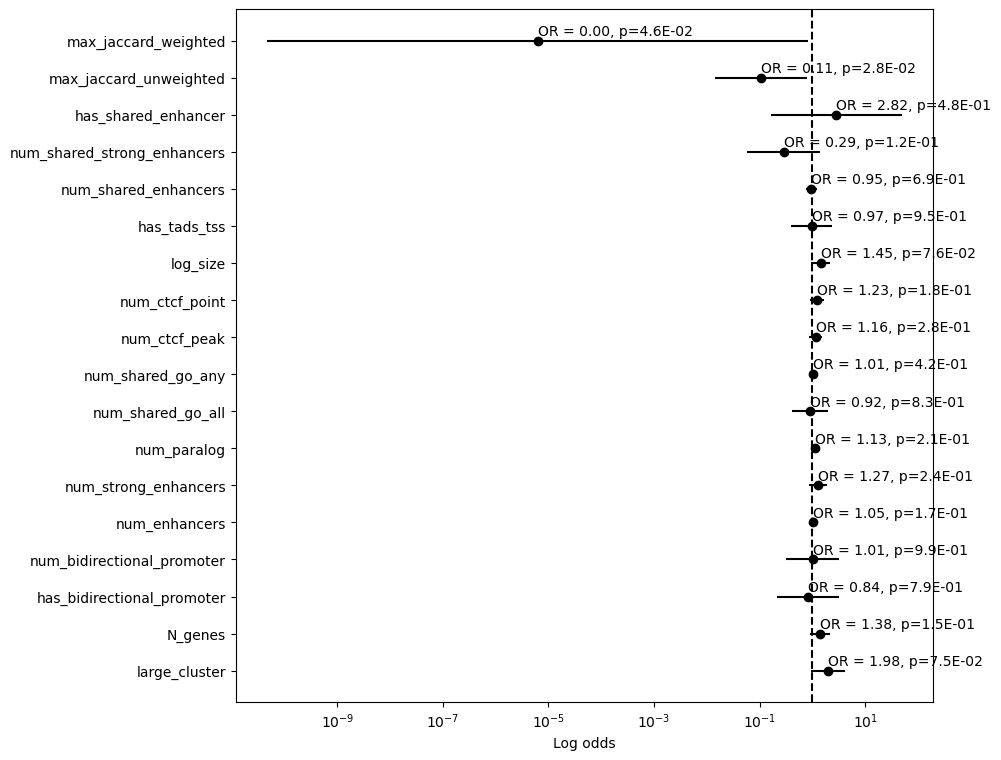

In [21]:
make_log_odds_plot(get_odds_df(joined_df))

or, instead of predicting is pc better or e better, regression model for the p value difference?



In [78]:
load_e_cis(config, my_tissue_id)

,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,qval,pval_nominal_threshold,cluster_id
phenotype_id,,,,,,,,,,,,,,,,,,,
ENSG00000187583.10_ENSG00000187642.9_e_ENSG00000187583.10,5284,1.04156,735.198,548.318,8.387670e-17,chr1_975014_C_T_b38,8517,-7079,403,503,0.356232,3.041580e-19,0.019998,0.002159,0.000100,1.710520e-14,1.236780e-14,0.000399,ENSG00000187583.10_ENSG00000187642.9
ENSG00000187583.10_ENSG00000187642.9_e_ENSG00000187642.9,5284,1.01810,713.349,547.379,8.091860e-14,chr1_981935_G_A_b38,15438,-158,241,269,0.190510,8.194630e-16,0.021998,0.002662,0.000100,3.738440e-11,2.278960e-11,0.000392,ENSG00000187583.10_ENSG00000187642.9
ENSG00000187608.8_ENSG00000188157.14_e_ENSG00000187608.8,5465,1.02793,531.643,501.686,5.533180e-04,chr1_1534019_T_C_b38,532881,513896,17,17,0.012040,1.007230e-04,0.039614,0.010122,0.245075,2.429010e-01,5.116860e-02,0.000537,ENSG00000187608.8_ENSG00000188157.14
ENSG00000187608.8_ENSG00000188157.14_e_ENSG00000188157.14,5465,1.00474,700.232,537.283,6.698400e-12,chr1_1020217_G_T_b38,19079,94,395,466,0.330028,8.113090e-14,-0.017583,0.002302,0.000100,4.274010e-09,2.273910e-09,0.000389,ENSG00000187608.8_ENSG00000188157.14
ENSG00000127054.20_ENSG00000224051.6_e_ENSG00000127054.20,6493,1.05556,991.496,557.640,1.004850e-14,chr1_1330080_T_C_b38,5389,5324,168,200,0.858357,1.397600e-16,-0.030942,0.003642,0.000100,2.379970e-12,1.559590e-12,0.000304,ENSG00000127054.20_ENSG00000224051.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000107317.12_ENSG00000214402.6_e_ENSG00000214402.6,7529,1.01908,1440.400,572.470,2.190520e-06,chr9_137002219_G_GTGCTGGAGGGGCGCC_b38,27127,19226,375,420,0.701923,6.005340e-07,-0.012338,0.002447,0.002500,2.799380e-03,8.658030e-04,0.000195,ENSG00000107317.12_ENSG00000214402.6
ENSG00000176058.11_ENSG00000187713.6_e_ENSG00000176058.11,6958,1.02242,1255.490,565.293,7.464230e-13,chr9_137190301_A_G_b38,-10497,-15337,322,367,0.259915,2.821220e-14,0.019128,0.002457,0.000100,5.823700e-10,3.308920e-10,0.000225,ENSG00000176058.11_ENSG00000187713.6
ENSG00000176058.11_ENSG00000187713.6_e_ENSG00000187713.6,6958,1.00955,1464.300,585.868,8.508600e-09,chr9_137190934_T_C_b38,-9864,-14704,361,421,0.298159,1.978560e-09,0.014680,0.002411,0.000100,1.113980e-05,4.510550e-06,0.000188,ENSG00000176058.11_ENSG00000187713.6


In [77]:
load_e_permutation(config, my_tissue_id)

,phenotype_id,num_var,beta_shape1,beta_shape2,true_df,pval_true_df,variant_id,start_distance,end_distance,ma_samples,ma_count,af,pval_nominal,slope,slope_se,pval_perm,pval_beta,rank,cluster_id
0,ENSG00000187583.10_ENSG00000187642.9_e_ENSG000...,5433,1.04090,732.346,542.396,1.198570e-26,chr1_975014_C_T_b38,8517,-7079,403,503,0.356232,7.956540e-31,0.031461,0.002582,0.000100,9.834130e-25,1,ENSG00000187583.10_ENSG00000187642.9
1,ENSG00000187583.10_ENSG00000187642.9_e_ENSG000...,5433,1.04902,712.624,538.849,5.659250e-07,chr1_975058_A_G_b38,8561,-7035,63,69,0.951133,5.883140e-08,-0.027380,0.004989,0.000300,2.690460e-04,2,ENSG00000187583.10_ENSG00000187642.9
2,ENSG00000187583.10_ENSG00000187642.9_e_ENSG000...,5433,1.04008,731.916,542.651,1.026120e-06,chr1_975093_G_A_b38,8596,-7000,189,202,0.143059,1.305670e-07,-0.018058,0.003382,0.000500,5.529690e-04,3,ENSG00000187583.10_ENSG00000187642.9
3,ENSG00000187583.10_ENSG00000187642.9_e_ENSG000...,5433,1.03113,731.585,544.274,6.632890e-05,chr1_1004111_TG_T_b38,37614,22018,286,320,0.226629,1.690830e-05,-0.011469,0.002645,0.041496,4.251850e-02,4,ENSG00000187583.10_ENSG00000187642.9
4,ENSG00000187583.10_ENSG00000187642.9_e_ENSG000...,5433,1.03107,751.122,549.779,9.175960e-14,chr1_981935_G_A_b38,15438,-158,241,269,0.190510,1.151520e-15,0.021593,0.002627,0.000100,3.286900e-11,1,ENSG00000187583.10_ENSG00000187642.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513,ENSG00000176058.11_ENSG00000187713.6_e_ENSG000...,7110,1.00224,1397.450,581.561,5.889660e-05,chr9_136667939_C_T_b38,-532859,-537699,66,68,0.048159,2.694600e-05,0.021276,0.005031,0.080192,7.849200e-02,2,ENSG00000176058.11_ENSG00000187713.6
3514,ENSG00000130653.15_ENSG00000165802.21_e_ENSG00...,5703,1.04052,1033.650,563.244,4.156300e-07,chr9_137549626_T_C_b38,90292,-908,517,677,0.520538,7.493560e-08,0.012211,0.002244,0.000500,3.082490e-04,1,ENSG00000130653.15_ENSG00000165802.21
3515,ENSG00000130653.15_ENSG00000165802.21_e_ENSG00...,5833,1.02339,962.453,558.965,1.658130e-30,chr9_137546725_A_G_b38,87391,-3809,514,672,0.524079,2.225670e-34,0.025936,0.001997,0.000100,3.732000e-28,1,ENSG00000130653.15_ENSG00000165802.21
3516,ENSG00000130653.15_ENSG00000165802.21_e_ENSG00...,5833,1.02020,1000.680,562.711,2.046370e-04,chr9_137496449_C_T_b38,37115,-54085,135,141,0.099858,8.093380e-05,0.013167,0.003319,0.174583,1.776190e-01,2,ENSG00000130653.15_ENSG00000165802.21


In [ ]:
ten

In [68]:
sum((cluster_pvals['qval_pc']<.05))

820

In [69]:
sum((cluster_pvals['qval_e']<.05))

849

In [70]:
print(sum((cluster_pvals['qval_pc']<.05)&(cluster_pvals['qval_e']>.05)))
print(sum((cluster_pvals['qval_pc']>.05)&(cluster_pvals['qval_e']<.05)))

14
43


In [91]:
sum(cluster_pvals['qval_pc']<.05)

1010

In [92]:
sum(cluster_pvals['qval_e']<.05)

979

# with nominal ps

In [22]:
e_nominal = load_e_nominal_all_chr(config, my_tissue_id)
pc_nominal = load_pc_nominal_all_chr(config, my_tissue_id)

FileNotFoundError: [Errno 2] No such file or directory: '/home/klawren/oak/pcqtls/output/proteincoding_corr_0.5/control_eqtl//Muscle_Skeletal/Muscle_Skeletal.v8.cluster_genes.cis_qtl_pairs.chr1.parquet'

In [9]:
# get the minimum per cluster p value
pc_pvals = pc_nominal.groupby('cluster_id').agg({'pval_nominal':min})
e_pvals = e_nominal.groupby('cluster_id').agg({'pval_nominal':min})

cluster_pvals = pd.merge(pc_pvals, e_pvals, on='cluster_id', suffixes=['_pc','_e'])
cluster_pvals['log_pc_pval'] = np.log10(cluster_pvals['pval_nominal_pc'])
cluster_pvals['log_e_pval'] = np.log10(cluster_pvals['pval_nominal_e'])

Text(0, 0.5, 'pcqtl min pvalue')

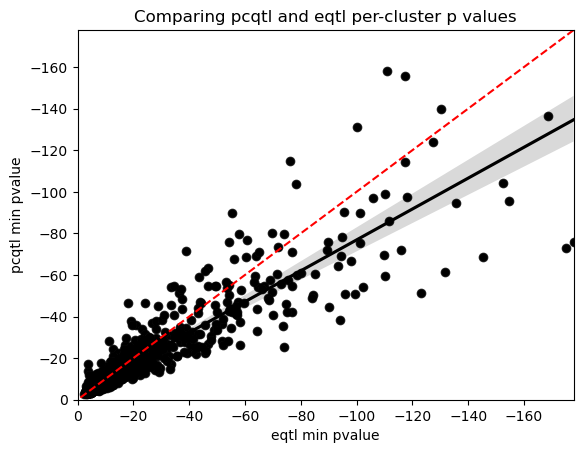

In [8]:
ax = sns.scatterplot(cluster_pvals, y='log_pc_pval', x='log_e_pval', color='k')
ax = sns.regplot(cluster_pvals, y='log_pc_pval', x='log_e_pval', color='k')

ax_lims = [pd.concat([cluster_pvals['log_pc_pval'], cluster_pvals['log_e_pval']]).min(),0]
ax.set_ylim(ax_lims)
ax.set_xlim(ax_lims)

ax.invert_yaxis()
ax.invert_xaxis()

# diagonal line
ax.plot(ax_lims, ax_lims, color='red', linestyle='--')

ax.set_title('Comparing pcqtl and eqtl per-cluster p values')
ax.set_xlabel('eqtl min pvalue')
ax.set_ylabel('pcqtl min pvalue')

In [15]:

ax = sns.scatterplot(cluster_pvals, y='pval_nominal_pc', x='pval_nominal_e', color='k')
ax = sns.regplot(cluster_pvals, y='pval_nominal_pc', x='pval_nominal_e', color='k')


# diagonal line

ax.set_title('Comparing pcqtl and eqtl per-cluster p values')
ax.set_xlabel('eqtl min pvalue')
ax.set_ylabel('pcqtl min pvalue')

ValueError: Could not interpret value `pval_nominal_e` for `x`. An entry with this name does not appear in `data`.

In [58]:
# try filtering to say, only clusters with very high correlation
cluster_df = load_cluster(config, my_tissue_id)
corr_cutoff = .5
high_cor_clusters = cluster_df[(cluster_df['Mean_pos_cor'] > corr_cutoff) | (cluster_df['Mean_neg_cor'] < -corr_cutoff)]['cluster_id']

Text(0, 0.5, 'pcqtl min pvalue')

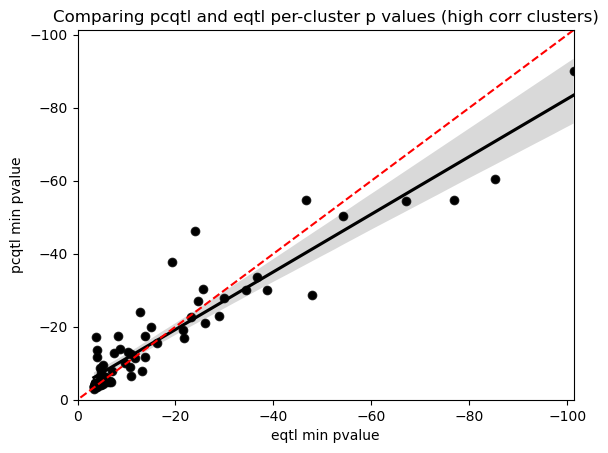

In [59]:
sub_cluster = cluster_pvals[cluster_pvals.index.isin(high_cor_clusters)]

ax = sns.scatterplot(sub_cluster, y='log_pc_pval', x='log_e_pval', color='k')
ax = sns.regplot(sub_cluster, y='log_pc_pval', x='log_e_pval', color='k')

ax_lims = [pd.concat([sub_cluster['log_pc_pval'], sub_cluster['log_e_pval']]).min(),0]
ax.set_ylim(ax_lims)
ax.set_xlim(ax_lims)
ax.invert_yaxis()
ax.invert_xaxis()

# diagonal line
ax.plot(ax_lims, ax_lims, color='red', linestyle='--')

ax.set_title('Comparing pcqtl and eqtl per-cluster p values (high corr clusters)')
ax.set_xlabel('eqtl min pvalue')
ax.set_ylabel('pcqtl min pvalue')

In [71]:
# filter to just multigene eqtls
overlap = load_overlap(config, my_tissue_id)
multigene_clusters = overlap[overlap['num_e_samelead'] > 1]['cluster_id']

Text(0, 0.5, 'pcqtl min pvalue')

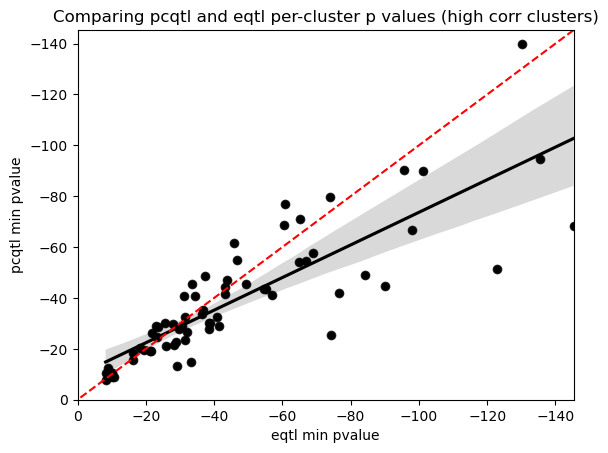

In [72]:
sub_cluster = cluster_pvals[cluster_pvals.index.isin(multigene_clusters)]

ax = sns.scatterplot(sub_cluster, y='log_pc_pval', x='log_e_pval', color='k')
ax = sns.regplot(sub_cluster, y='log_pc_pval', x='log_e_pval', color='k')

ax_lims = [pd.concat([sub_cluster['log_pc_pval'], sub_cluster['log_e_pval']]).min(),0]
ax.set_ylim(ax_lims)
ax.set_xlim(ax_lims)
ax.invert_yaxis()
ax.invert_xaxis()

# diagonal line
ax.plot(ax_lims, ax_lims, color='red', linestyle='--')

ax.set_title('Comparing pcqtl and eqtl per-cluster p values (high corr clusters)')
ax.set_xlabel('eqtl min pvalue')
ax.set_ylabel('pcqtl min pvalue')